# Plotting CO Ice for the Filament

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import astropy.units as u 
from astropy.coordinates import SkyCoord
import regions
from regions import Regions
from astropy.table import Table

from spectral_cube import SpectralCube
import importlib as imp
from icemodels.core import composition_to_molweight
from brick2221.analysis.make_icecolumn_fig9 import dmag_tbl # 

from dust_extinction.averages import CT06_MWLoc, I05_MWAvg, CT06_MWGC, G21_MWAvg, RL85_MWGC, RRP89_MWGC, F11_MWGC

Loaded merged1182_daophot_basic_indivexp (2025-03-24 version)


In [2]:
#from brick2221.analysis.make_icecolumn_fig9 import molscomps, compute_molecular_column
from brick2221.analysis.analysis_setup import basepath, molscomps, compute_molecular_column
dmag_tbl = Table.read(f'{basepath}/tables/combined_ice_absorption_tables.ecsv')
dmag_tbl.add_index('composition')

In [3]:
%cd ..
from jwst_plots import JWSTCatalog, make_cat_use, make_brick_cat
import cutout_manager as cm
import jwst_plots
import co_ice as co_map
imp.reload(co_map)
import extinction as ex
%cd notebooks

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament
/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [4]:
reg_f = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/filament_short.region')
reg_c1 = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudc1.region')
reg_c2 = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudc2.region')
reg_d = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudd.region')

In [5]:
fn = '/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits'
#fn = '/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged-nodestreak_i2d-perfilt64.fits'
hdu_405 = fits.open(fn)
data_405 = hdu_405[1].data
head_405 = hdu_405[1].header
blank_405 = np.zeros_like(data_405)*np.nan

## Catalog

In [7]:
cat_use = make_cat_use()

In [8]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

cutout_filament = cm.Cutout(pos, w, l)
cutout_405 = cutout_filament.get_cutout_405()

In [9]:
cat_filament = JWSTCatalog(cat_use.table_region_mask([reg], cutout_405.wcs))
#mask_red = (cat_filament.color('f182m', 'f410m') > 2) | (np.isnan(np.array(cat_filament.band('f182m'))) & np.isnan(np.array(cat_filament.band('f187n'))))
mask_red = (cat_filament.color('f182m', 'f212n') > 0.55) | (np.isnan(np.array(cat_filament.band('f182m'))) & np.isnan(np.array(cat_filament.band('f187n'))))
mask_red = mask_red & (cat_filament.color('f410m', 'f466n') < 0)
cat_filament = JWSTCatalog(cat_filament.catalog[mask_red])

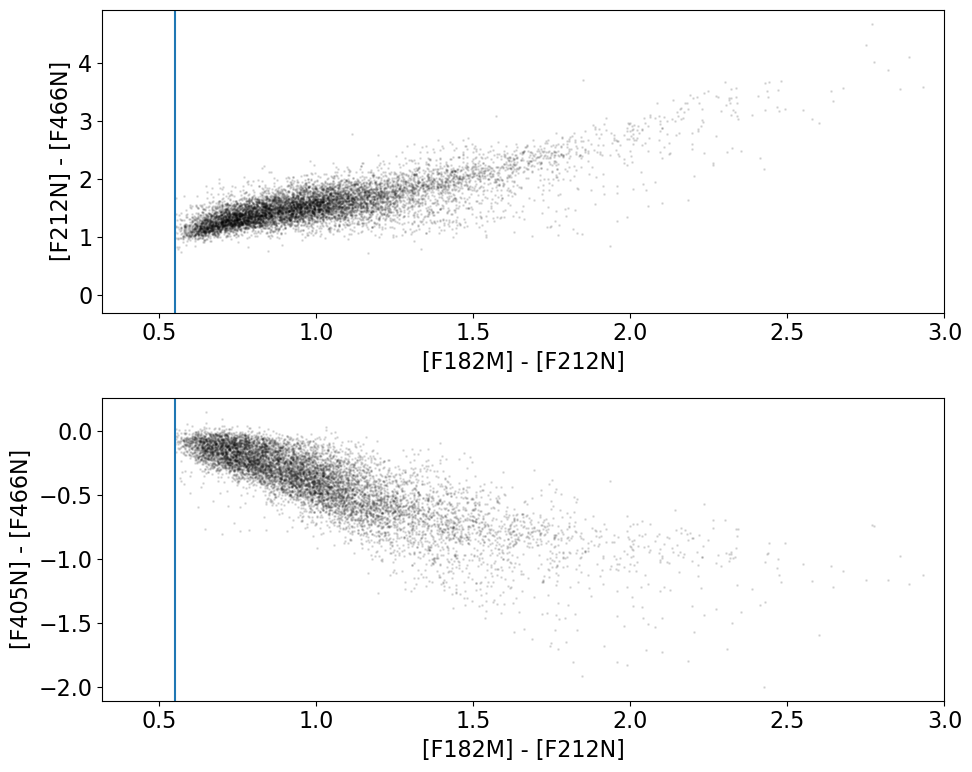

In [10]:
ax1 = plt.subplot(211)
cat_filament.plot_CCD('f182m', 'f212n', 'f212n', 'f466n', color='k', s=1, ax=ax1, alpha=0.1)
ax1.set_xlim(right=3)

ax2 = plt.subplot(212)
cat_filament.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', color='k', s=1, ax=ax2, alpha=0.1)
ax2.set_xlim(right=3)

ax1.axvline(0.55)
ax2.axvline(0.55)

plt.tight_layout()

In [11]:
#reg_f = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/filament_short.region')
cat_f = JWSTCatalog(cat_use.table_region_mask(reg_f, cutout_405.wcs))
mask_red = (cat_f.color('f182m', 'f212n') > 0.55) | (np.isnan(np.array(cat_f.band('f182m'))) & np.isnan(np.array(cat_f.band('f187n'))))
mask_red = mask_red & (cat_f.color('f410m', 'f466n') < 0)
cat_f = JWSTCatalog(cat_f.catalog[mask_red])

(0.0, 3.0)

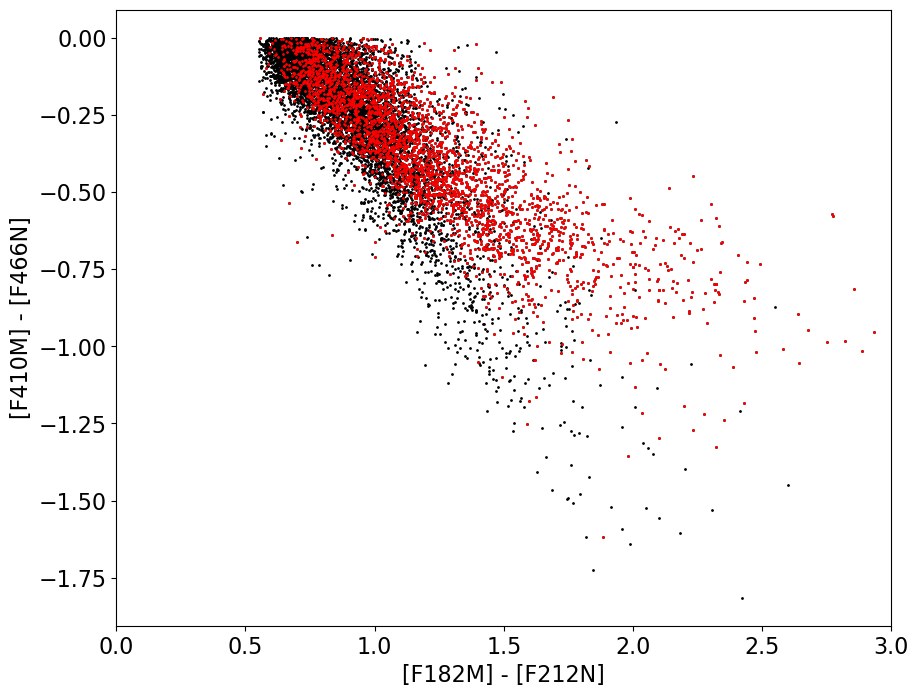

In [12]:
ax = plt.subplot(111)
cat_filament.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', ax=ax, color='k', s=1)
cat_f.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', ax=ax, color='r', s=1)
ax.set_xlim(0, 3)

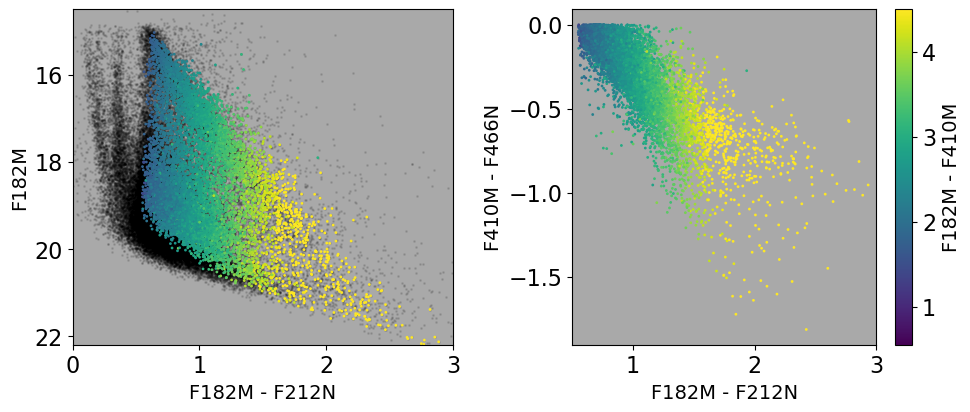

In [13]:
ax1 = plt.subplot(221)
ax1.set_facecolor('darkgrey')
cat_use.plot_CMD('f182m', 'f212n', 'f182m', color='k', s=1, ax=ax1, alpha=0.1)
cat_filament.plot_CMD('f182m', 'f212n', 'f182m', ax=ax1, s=1, cmap='viridis', c=cat_filament.color('f182m', 'f410m'), vmin=0.55, vmax=4.5)
plt.gca().invert_yaxis()
ax1.set_xlabel('F182M - F212N', fontsize=14)
ax1.set_ylabel('F182M', fontsize=14)
ax1.set_xlim(0, 3)
ax1.set_ylim(22.2, 14.5)

ax = plt.subplot(222)
ax.set_facecolor('darkgrey')
#cat_filament.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', ax=ax, s=1, cmap='viridis', c=cat_filament.color('f182m', 'f212n'), vmin=0.5, vmax=3)
im = ax.scatter(cat_filament.color('f182m', 'f212n'), cat_filament.color('f410m', 'f466n'), s=1, c=cat_filament.color('f182m', 'f410m'), vmin=0.55, vmax=4.5, cmap='viridis')
ax.set_xlabel('F182M - F212N', fontsize=14)
ax.set_ylabel('F410M - F466N', fontsize=14)
ax.set_xlim(0.5, 3)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('F182M - F410M', fontsize=14)
plt.tight_layout()
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/poster_filament_color_color.svg', dpi=300, bbox_inches='tight')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/poster_filament_color_color.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/poster_filament_color_color.png', dpi=300, bbox_inches='tight')

In [14]:
ridge_reg = [reg_d[0], reg_c1[0], reg_c2[0]]
cat_ridge = JWSTCatalog(cat_use.table_region_mask(ridge_reg, cutout_405.wcs))
mask_red = (cat_ridge.color('f182m', 'f212n') > 0.8) | (np.isnan(np.array(cat_ridge.band('f182m'))) & np.isnan(np.array(cat_ridge.band('f187n'))))
mask_red = mask_red & (cat_ridge.color('f410m', 'f466n') < 0)
cat_ridge = JWSTCatalog(cat_ridge.catalog[mask_red])

(0.5, 3.0)

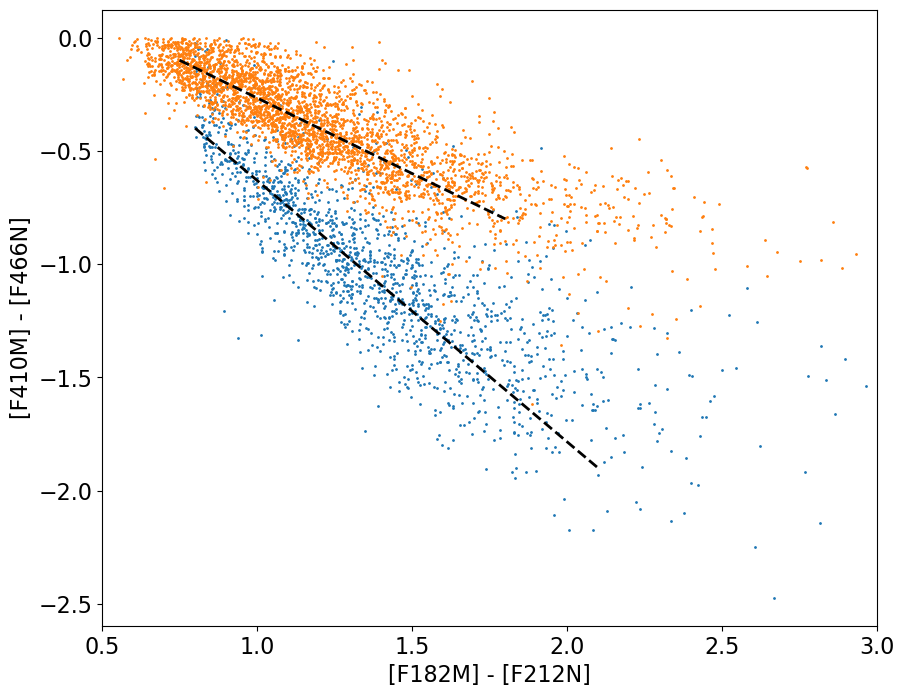

In [17]:
ax = plt.subplot(111)
cat_ridge.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', ax=ax, s=1, color='tab:blue')
ax.plot([0.8, 2.1], [-0.4, -1.9], color='k', linestyle='--', label='dust ridge', lw=2)
cat_f.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', ax=ax, s=1, color='tab:orange')
ax.plot([0.75, 1.8], [-0.1, -0.8], color='k', linestyle='--', label='filament', lw=2)

ax.set_xlim(0.5, 3)

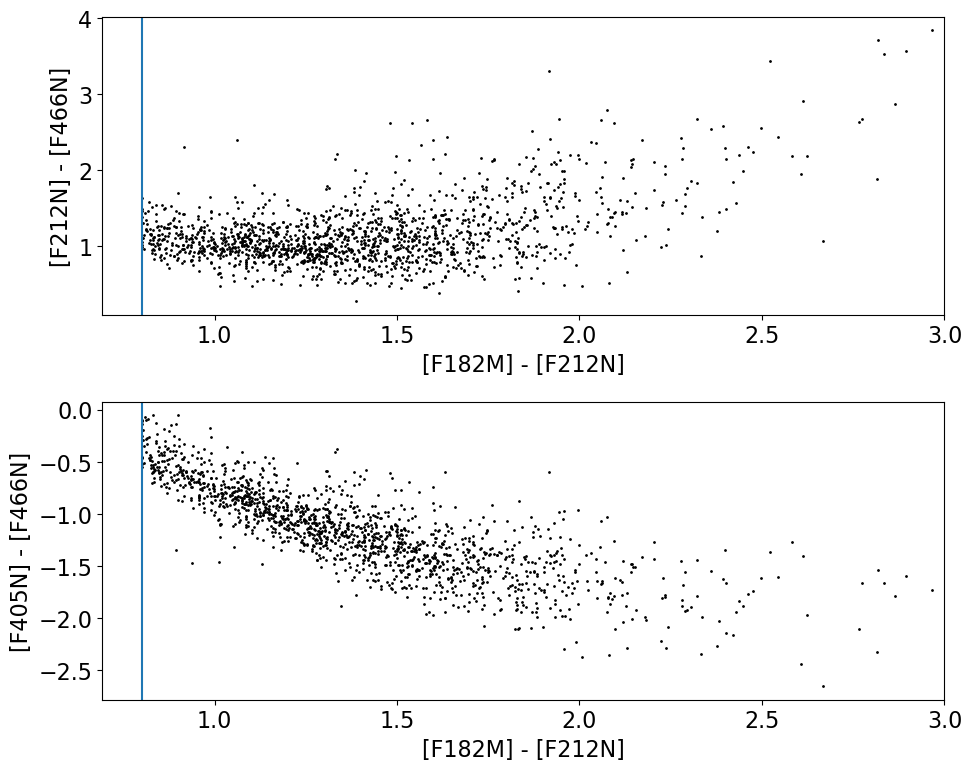

In [18]:
ax1 = plt.subplot(211)
cat_ridge.plot_CCD('f182m', 'f212n', 'f212n', 'f466n', color='k', s=1, ax=ax1)
ax1.set_xlim(right=3)

ax2 = plt.subplot(212)
cat_ridge.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', color='k', s=1, ax=ax2)
ax2.set_xlim(right=3)

ax1.axvline(0.8)
ax2.axvline(0.8)

plt.tight_layout()

## CO Ice

In [19]:
Av_182212_filament = cat_filament.get_Av('f182m', 'f212n', ext=CT06_MWLoc())
Av_182212_ridge = cat_ridge.get_Av('f182m', 'f212n', ext=CT06_MWLoc())
Av_182212_f = cat_f.get_Av('f182m', 'f212n', ext=CT06_MWLoc())
#cat_filament.catalog['N(CO)'] = co_map.get_co_column(cat_filament, Av_182212, ref_band='f212n', ext=CT06_MWLoc(), consts_file='85_CO_(1)_10K_Hudgins.txt')

In [20]:
cat_filament.catalog['N(CO)'] = co_map.get_co_ice_column(cat_filament, Av_182212_filament, ext=CT06_MWLoc(), ref_band='f410m') # H2O:CO_(10:1)
cat_ridge.catalog['N(CO)'] = co_map.get_co_ice_column(cat_ridge, Av_182212_ridge, ext=CT06_MWGC(), ref_band='f410m') # H2O:CO_(10:1)
cat_f.catalog['N(CO)'] = co_map.get_co_ice_column(cat_f, Av_182212_f, ext=CT06_MWLoc(), ref_band='f410m') # H2O:CO_(10:1)

In [21]:
# McClure https://arxiv.org/pdf/2301.09140
J110621 = (95, 10**18.6)
NIR38 = (60, 10**18.45)
elias16 = (19, 10**18.3)

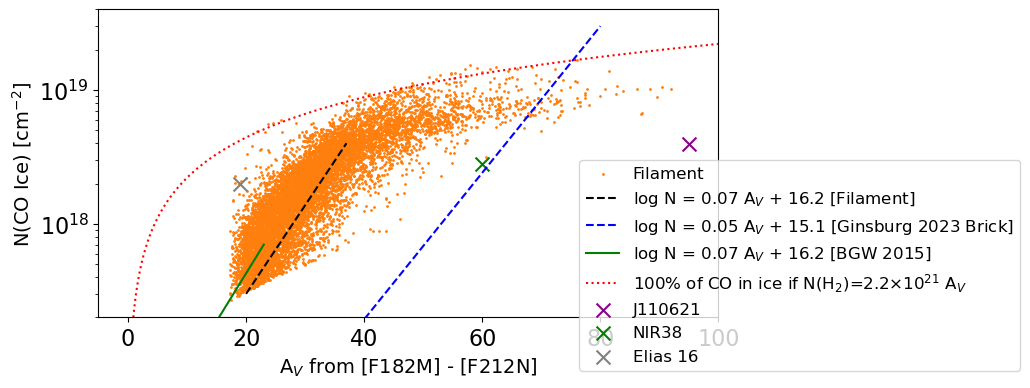

In [22]:
plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
#ax.set_facecolor('darkgrey')
# plt.scatter(Av_182212_filament, cat_filament.catalog['N(CO)'], color='k', s=1)
co_map.plot_Av_COice(Av_182212_filament, cat_filament.catalog['N(CO)'], extras=True, color='tab:orange', s=1, label='Filament')
plt.scatter(J110621[0], J110621[1], color='darkmagenta', s=100, marker='x', label='J110621')
plt.scatter(NIR38[0], NIR38[1], color='green', s=100, marker='x', label='NIR38')
plt.scatter(elias16[0], elias16[1], color='gray', s=100, marker='x', label='Elias 16')
#plt.scatter(Av_182212_ridge, cat_ridge.catalog['N(CO)'], color='tab:blue', s=1, label='Dust Ridge')
plt.yscale('log')
plt.xlabel('A$_V$ from [F182M] - [F212N]', fontsize=14)
plt.ylabel('N(CO Ice) [cm$^{-2}$]', fontsize=14)
plt.xlim(right=100)
plt.ylim(2e17, 4e19)
pt1 = (20, 3e17)
pt2 = (37, 4e18)
#plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], label='Filament', color='k', linestyle='--')

plt.legend(loc='lower right', bbox_to_anchor=(1.5, -0.2), fontsize=12)
#plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/poster_filament_Av_CO_ice.svg', dpi=300, bbox_inches='tight')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/poster_filament_Av_CO_ice.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/poster_filament_Av_CO_ice.png', dpi=300, bbox_inches='tight')

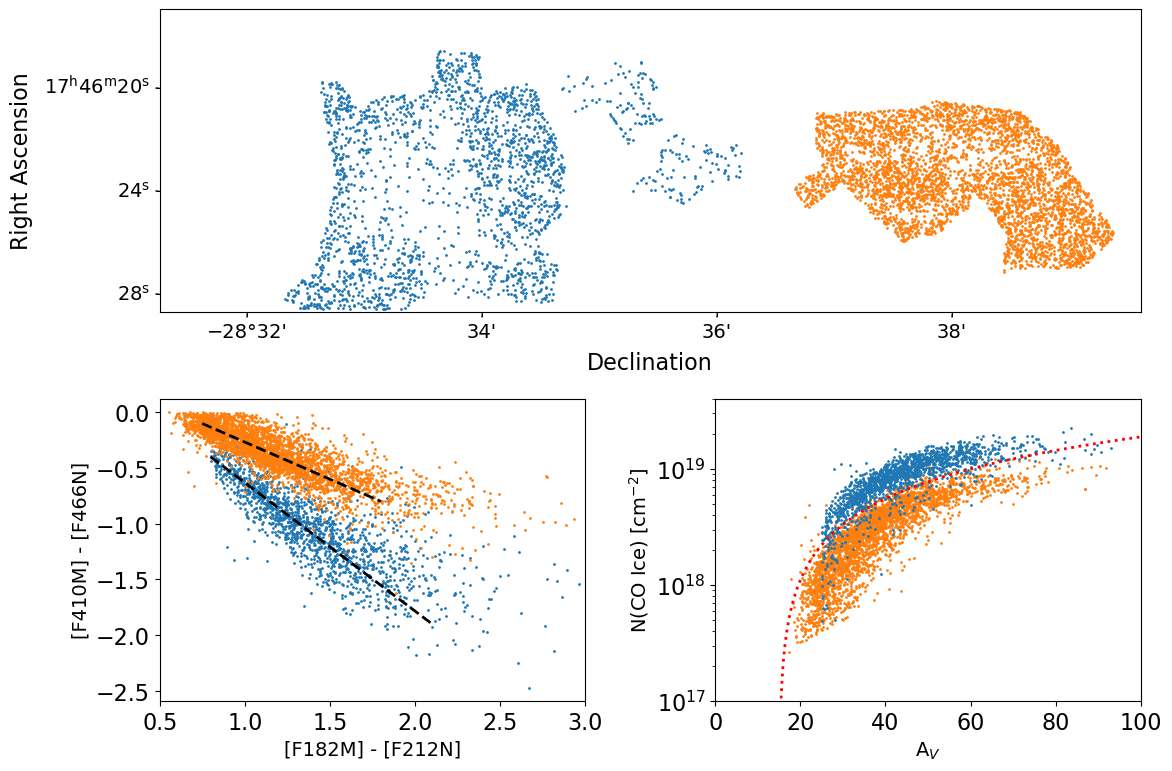

In [23]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(211, projection=WCS(head_405))
ax.imshow(blank_405)
cat_ridge.plot_position(ax=ax, transform=ax.get_transform('world'), s=1, color='tab:blue')
cat_f.plot_position(ax=ax, transform=ax.get_transform('world'), s=1, color='tab:orange')
dec = ax.coords[1]
ra = ax.coords[0]
dec.set_ticks_position('b')
dec.set_ticklabel_position('b')
dec.set_axislabel_position('b')
dec.set_ticklabel(size=14)
ra.set_ticks_position('l')
ra.set_ticklabel_position('l')
ra.set_axislabel_position('l')
ra.set_ticklabel(size=14)
ax.set_ylabel('Right Ascension', fontsize=16)
ax.set_xlabel('Declination', fontsize=16)

ax1 = plt.subplot(223)
cat_ridge.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', ax=ax1, s=1, color='tab:blue')
cat_f.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', ax=ax1, s=1, color='tab:orange')
ax1.set_xlim(0.5, 3)
ax1.plot([0.8, 2.1], [-0.4, -1.9], color='k', linestyle='--', label='dust ridge', lw=2)
ax1.plot([0.75, 1.8], [-0.1, -0.8], color='k', linestyle='--', label='filament', lw=2)
ax1.set_xlabel('[F182M] - [F212N]', fontsize=14)
ax1.set_ylabel('[F410M] - [F466N]', fontsize=14)

ax2 = plt.subplot(224)
ax2.scatter(Av_182212_f, cat_f.catalog['N(CO)'], color='tab:orange', s=1, label='Filament')
ax2.scatter(Av_182212_ridge, cat_ridge.catalog['N(CO)'], color='tab:blue', s=1, label='Dust Ridge')
ax2.set_yscale('log')
ax2.set_xlabel('A$_V$', fontsize=14)
ax2.set_ylabel('N(CO Ice) [cm$^{-2}$]', fontsize=14)
ax2.set_xlim(0, 100)
ax2.set_ylim(1e17, 4e19)
pt1 = (20, 3e17)
pt2 = (37, 4e18)
NCOofAV = 2.21e21 * np.linspace(0.1, 100, 1000) * 1e-4
ax2.plot(np.linspace(0.1, 100, 1000)+15, NCOofAV, lw=2,
            label='100% of CO in ice if N(H$_2$)=2.2$\\times10^{21}$ A$_V$', color='r', linestyle=':')

#plt.legend(loc='lower right', bbox_to_anchor=(1.2, 0.0), fontsize=12)

plt.tight_layout()
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/poster_spatial_CO_ice.svg', dpi=300, bbox_inches='tight')

In [24]:
# Define the physical size and distance
L = 0.5 * u.pc  # physical size in parsecs
D = 5 * u.kpc   # distance in kiloparsecs

# Calculate the angular size in radians
theta_rad = (L / D).to(u.radian, equivalencies=u.dimensionless_angles())

# Convert the angular size to arcseconds
theta_arcsec = theta_rad.to(u.arcsec)

In [25]:
from astropy.visualization.wcsaxes import add_scalebar


In [26]:
co_col_map = co_map.make_co_column_map(cat_filament, cat_filament.catalog['N(CO)'], cutout_405.wcs, cutout_405.shape, fwhm=30, k=5)

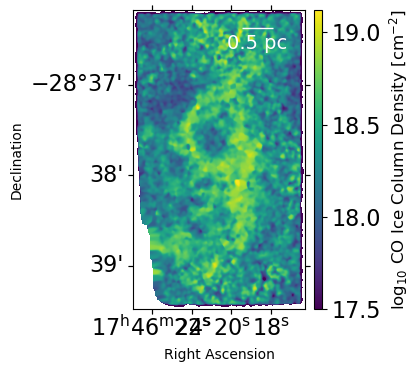

In [27]:
fig = plt.figure(figsize=(8, 4))
co_col_map[co_col_map < 1e16] = np.nan
ax = plt.subplot(projection=cutout_405.wcs)
im = ax.imshow(np.log10(co_col_map), origin='lower', cmap='viridis', vmin=17.5)#, vmin=20, vmax=21)
#plt.colorbar(im, ax=ax, label='log(N(CO) [cm$^{-2}$])')
cbax = ax.inset_axes([1.05, 0.0, 0.05, 1])  
cbar = plt.colorbar(mappable=im, cax=cbax)
cbar.set_label("log$_{10}$ CO Ice Column Density [cm$^{-2}$]", fontsize=12)
ax.set_xlabel('Right Ascension', fontsize=10)
ax.set_ylabel('Declination', fontsize=10)
#ax.set_axis_off()
plt.tight_layout()
add_scalebar(ax, theta_arcsec, color='white', label='0.5 pc', corner='top right', fontproperties={"size": 14})
#plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/poster_co_ice_column_map.svg', dpi=300, bbox_inches='tight')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/poster_co_ice_column_map.pdf', dpi=300, bbox_inches='tight')

In [25]:
hdu_COice = fits.PrimaryHDU(co_col_map, header=cutout_405.wcs.to_header())
hdu_COice.writeto('/orange/adamginsburg/jwst/cloudc/images/filament_co_ice_col_map.fits', overwrite=True)

In [28]:
co_col_map_2 = co_map.make_co_column_map(cat_filament, cat_filament.catalog['N(CO)'], cutout_405.wcs, cutout_405.shape, fwhm=20, k=5)

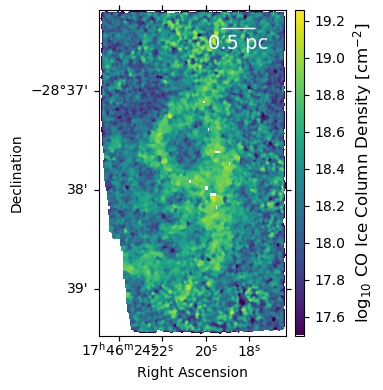

In [29]:
fig = plt.figure(figsize=(8, 4))
co_col_map_2[co_col_map_2 < 1e16] = np.nan
ax = plt.subplot(projection=cutout_405.wcs)
im = ax.imshow(np.log10(co_col_map_2), origin='lower', cmap='viridis', vmin=17.5)#, vmin=20, vmax=21)
#plt.colorbar(im, ax=ax, label='log(N(CO) [cm$^{-2}$])')
cbax = ax.inset_axes([1.05, 0.0, 0.05, 1])  
cbar = plt.colorbar(mappable=im, cax=cbax)
cbar.set_label("log$_{10}$ CO Ice Column Density [cm$^{-2}$]", fontsize=12)
ax.set_xlabel('Right Ascension', fontsize=10)
ax.set_ylabel('Declination', fontsize=10)
#ax.set_axis_off()
plt.tight_layout()
add_scalebar(ax, theta_arcsec, color='white', label='0.5 pc', corner='top right', fontproperties={"size": 14})

# Comparison to Nature Paper

https://www.nature.com/articles/s41550-025-02511-z

In [28]:
from astropy.table import Table
tab = Table.read('tab_dat.csv', delimiter=' ')#.write('tab_dat.fits', format='fits', overwrite=True)
#  (J2000) (J2000) (10^18 cm^−2) (10^18 cm^−2) (10^18 cm^−2)    (10^22 cm^−2) (mJy)
#tab.units = {'RA': u.deg, 'DEC': u.deg, 'F410M': u.mJy}#, 'N_HI': u.cm**-2, 'N_H2': u.cm**-2, 'N_H_tot': u.cm**-2, 'N_H_tot_err': u.cm**-2, 'flux_187': u.mJy}
tab['F410M'].unit = u.mJy
tab['RA'].unit = u.deg
tab['Dec'].unit = u.deg
tab['NH2'].unit = 10**22 * u.cm**-2
tab['NH2O'].unit = 10**18 * u.cm**-2
tab['NCO2'].unit = 10**18 * u.cm**-2
tab['NCO'].unit = 10**18 * u.cm**-2
tab['Av'] = tab['NH2']*10**22 * u.cm**-2 / (2.21e21 * u.cm**-2)  # Convert to Av using NH2 to Av conversion factor
tab['Av'].unit = u.mag  # Av is in magnitudes
tab

ID,RA,Dec,NH2O,NCO2,NCO,CO2/H2O,CO/H2O,CO2/CO,NH2,F410M,Av
,deg,deg,1e+18 / cm2,1e+18 / cm2,1e+18 / cm2,,,,1e+22 / cm2,mJy,mag
str4,float64,str9,str14,str14,str14,str14,str14,str14,float64,float64,float64
13*,166.52798,−77.41515,4.82+1.04−0.67,1.54+0.08−0.08,0.81+0.81−0.66,0.32+0.07−0.05,0.17+0.17−0.14,1.90+1.90−1.55,1.54,0.013,6.968325791855204
16*,166.53697,−77.41404,5.75+1.47−1.26,1.18+0.05−0.05,1.55+0.74−0.68,0.21+0.05−0.05,0.27+0.15−0.13,0.76+0.37−0.33,1.78,0.012,8.054298642533936
28,166.58333,−77.40956,6.30+1.18−1.68,2.57+0.04−0.04,2.87+0.29−0.32,0.41+0.08−0.11,0.46+0.10−0.13,0.89+0.09−0.10,2.46,0.017,11.131221719457013
30*,166.51774,−77.40859,5.51+2.17−1.61,1.10+0.04−0.04,1.84+0.53−0.59,0.20+0.08−0.06,0.33+0.16−0.14,0.60+0.17−0.19,1.44,0.006,6.515837104072398
33,166.55776,−77.40736,4.76+0.99−1.24,1.10+0.01−0.01,1.38+0.17−0.17,0.23+0.05−0.06,0.29+0.07−0.08,0.80+0.10−0.10,2.34,0.011,10.588235294117647
34*,166.52572,−77.40734,5.65+2.04−1.47,0.99+0.08−0.08,2.27+0.40−0.44,0.17+0.06−0.05,0.40+0.16−0.13,0.44+0.09−0.09,1.52,0.008,6.877828054298643
36*,166.53468,−77.40576,5.53+1.15−1.08,1.28+0.03−0.03,1.64+0.02−0.02,0.23+0.05−0.05,0.30+0.06−0.06,0.78+0.02−0.02,1.66,0.045,7.51131221719457
37,166.56797,−77.40469,7.83+0.64−0.70,2.77+0.05−0.06,2.79+0.04−0.04,0.35+0.03−0.03,0.36+0.03−0.03,0.99+0.02−0.03,2.91,0.023,13.16742081447964


In [29]:
#tab['NCO']
NCO_ice = np.zeros(len(tab['NCO']))
NCO_perr = np.zeros_like(NCO_ice)
NCO_nerr = np.zeros_like(NCO_ice)
Av_ice = np.array(tab['Av'])

for i in range(len(NCO_ice)):
    NCO_ice[i] = np.float64(np.array(tab['NCO'])[i].split('+')[0])
    NCO_perr[i] = np.float64(np.array(tab['NCO'])[i].split('+')[1].split("−")[0])
    NCO_nerr[i] = np.float64(np.array(tab['NCO'])[i].split('+')[1].split("−")[1])

NCO_ice = NCO_ice * 1e18  # Convert to cm^-2 for consistency with other values
NCO_perr = NCO_perr * 1e18
NCO_nerr = NCO_nerr * 1e18


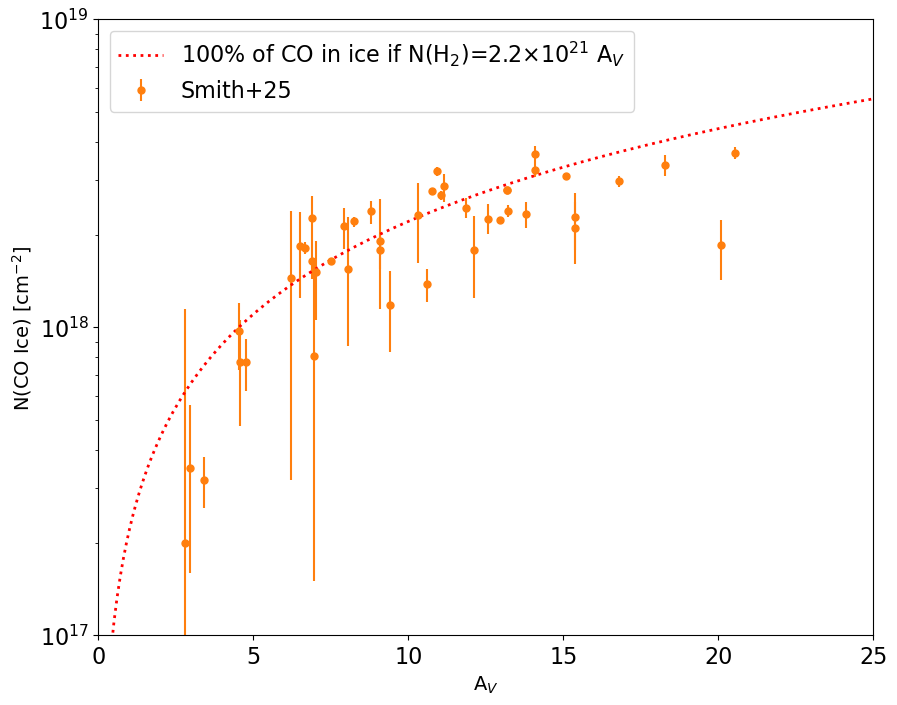

In [30]:
ax = plt.subplot(111)
ax.errorbar(Av_ice, NCO_ice, yerr=[NCO_nerr, NCO_perr], color='tab:orange', marker='o', markersize=5, linestyle='none', label='Smith+25')
ax.set_yscale('log')
ax.set_xlim(0, 100)
ax.set_ylim(1e17, 4e19)
ax.set_xlabel('A$_V$', fontsize=14)
ax.set_ylabel('N(CO Ice) [cm$^{-2}$]', fontsize=14)
NCOofAV = 2.21e21 * np.linspace(0.1, 100, 1000) * 1e-4
ax.plot(np.linspace(0.1, 100, 1000), NCOofAV, lw=2,
            label='100% of CO in ice if N(H$_2$)=2.2$\\times10^{21}$ A$_V$', color='r', linestyle=':')
plt.axis([0,25,1e17,1e19]);
ax.legend()
plt.savefig("/orange/adamginsburg/jwst/cloudc/figures/Smith2025_IceVsAV.pdf", bbox_inches='tight')

# Other Extinction Laws

In [22]:
def make_col_map(ext):
    Av_182212 = cat_filament.get_Av('f182m', 'f212n', ext=ext)
    cat_filament.catalog['N(CO)'] = co_map.get_co_ice_column(cat_filament, Av_182212, ext=ext, ref_band='f410m') # H2O:CO_(10:1)
    co_col_map = co_map.make_co_column_map(cat_filament, cat_filament.catalog['N(CO)'], cutout_405.wcs, cutout_405.shape, fwhm=30, k=5)
    co_col_map[co_col_map < 1e16] = np.nan
    return co_col_map

def cal_mass(co_col_map, ww):
    co_abundance = 10**(-4)
    pixel_area_physical = (ww.proj_plane_pixel_scales()[0] * 5*u.kpc).to(u.cm, u.dimensionless_angles())**2
    mpp = 2.8*u.Da
    # grid_interp = N(CO) map after interpolation
    mass_co_ice = (np.nansum(co_col_map) * u.cm**(-2) * pixel_area_physical * mpp / co_abundance).to(u.Msun)
    return mass_co_ice

In [11]:
from dust_extinction.averages import RL85_MWGC, RRP89_MWGC, B92_MWAvg, I05_MWAvg, CT06_MWLoc, CT06_MWGC, GCC09_MWAvg, F11_MWGC, G21_MWAvg, D22_MWAvg
ext_laws = [RL85_MWGC(), RRP89_MWGC(), I05_MWAvg(), CT06_MWLoc(), CT06_MWGC(), F11_MWGC(), G21_MWAvg(), D22_MWAvg()]

In [23]:
ext = CT06_MWLoc()
co_col_map = make_col_map(ext)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 7335.12460916 solMass>

In [24]:
ext = CT06_MWGC()
co_col_map = make_col_map(ext)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 7335.12460916 solMass>

In [25]:
ext = I05_MWAvg()
co_col_map = make_col_map(ext)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 7281.46196539 solMass>

In [26]:
ext = RRP89_MWGC()
co_col_map = make_col_map(ext)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 13213.26456411 solMass>

In [27]:
ext = D22_MWAvg()
co_col_map = make_col_map(ext)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 8537.01718698 solMass>

In [28]:
ext = G21_MWAvg()
co_col_map = make_col_map(ext)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 9203.34186451 solMass>

In [29]:
ext = RL85_MWGC()
co_col_map = make_col_map(ext)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 12282.9321109 solMass>

In [30]:
ext = F11_MWGC()
co_col_map = make_col_map(ext)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 4819.8143392 solMass>

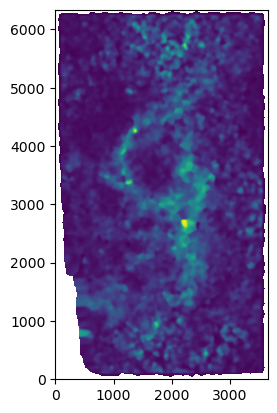

In [31]:
plt.imshow(co_col_map)

## Using Filament cutout

In [32]:
reg_f = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/filament_short.region')

In [33]:
def apply_reg(col_map, reg, ww):
    pix_reg = reg[0].to_pixel(ww)
    mask = pix_reg.to_mask()
    col_map_masked = mask.multiply(col_map)
    col_map_masked[col_map_masked <= 0] = np.nan
    return col_map_masked

In [34]:
ext = CT06_MWLoc()
co_col_map = make_col_map(ext)
co_col_map = apply_reg(co_col_map, reg_f, cutout_405.wcs)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 4079.11230443 solMass>

In [36]:
ext = CT06_MWGC()
co_col_map = make_col_map(ext)
co_col_map = apply_reg(co_col_map, reg_f, cutout_405.wcs)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 4079.11230443 solMass>

In [37]:
ext = I05_MWAvg()
co_col_map = make_col_map(ext)
co_col_map = apply_reg(co_col_map, reg_f, cutout_405.wcs)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 4051.9961862 solMass>

In [38]:
ext = RRP89_MWGC()
co_col_map = make_col_map(ext)
co_col_map = apply_reg(co_col_map, reg_f, cutout_405.wcs)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 6967.24126006 solMass>

In [39]:
ext = D22_MWAvg()
co_col_map = make_col_map(ext)
co_col_map = apply_reg(co_col_map, reg_f, cutout_405.wcs)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 4682.30542555 solMass>

In [40]:
ext = G21_MWAvg()
co_col_map = make_col_map(ext)
co_col_map = apply_reg(co_col_map, reg_f, cutout_405.wcs)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 5013.27491776 solMass>

In [41]:
ext = RL85_MWGC()
co_col_map = make_col_map(ext)
co_col_map = apply_reg(co_col_map, reg_f, cutout_405.wcs)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 6518.83122072 solMass>

In [42]:
ext = F11_MWGC()
co_col_map = make_col_map(ext)
co_col_map = apply_reg(co_col_map, reg_f, cutout_405.wcs)
mass_co_ice = cal_mass(co_col_map, cutout_405.wcs)
mass_co_ice

<Quantity 2790.82112009 solMass>